In [1]:
# libraries installation
!pip install lifelines matplotlib
!pip install lifelines




In [3]:

import pandas as pd
import numpy as np

# Loading with no header
df_raw = pd.read_excel("RADCURE_Clinical_v04_20241219.xlsx", 
                       sheet_name="RADCURE_TCIA_Clinical_r2_offset", 
                       header=None)

# Assigning correct column names
columns = ['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status', 'Ds Site',
           'Subsite', 'T', 'N', 'M', 'Stage', 'Path', 'HPV', 'Tx Modality', 'Chemo', 'RT Start',
           'Dose', 'Fx', 'Last FU', 'Status', 'Length FU', 'Date of Death', 'Cause of Death',
           'Local', 'Date Local', 'Regional', 'Date Regional', 'Distant', 'Date Distant',
           '2nd Ca', 'Date 2nd Ca', 'RADCURE-challenge', 'ContrastEnhanced']

df_raw.columns = columns[:df_raw.shape[1]]  # truncate if fewer columns

# Keeping only required columns and rename
df = df_raw[['Age', 'Length FU', 'Status']].copy()
df = df.rename(columns={'Length FU': 'survival_time', 'Status': 'event'})

# Droping rows with missing essential data
df = df.dropna(subset=['Age', 'survival_time', 'event'])

# Converting event values to numeric (Dead = 1, Alive = 0)
df['event'] = df['event'].map({'Dead': 1, 'Alive': 0})
df = df.dropna(subset=['event'])  # drop rows where event is still NaN

# Ensuring numeric types
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['survival_time'] = pd.to_numeric(df['survival_time'], errors='coerce')
df = df.dropna(subset=['Age', 'survival_time'])

# Creating Age groups
df['age_group'] = df['Age'].apply(lambda x: '<65' if x < 65 else '≥65')

# Final confirmation
print("✅ Cleaned Data Sample:\n", df.head())
print("\n✅ Age group counts:\n", df['age_group'].value_counts())


✅ Cleaned Data Sample:
     Age  survival_time  event age_group
1  62.6       1.317808    1.0       <65
2  87.3       1.520548    1.0       ≥65
3  49.9       2.126027    0.0       <65
4  72.3       5.791781    0.0       ≥65
5  59.7       9.512329    0.0       <65

✅ Age group counts:
 age_group
<65    1987
≥65    1359
Name: count, dtype: int64



📊 Log-rank test p-value: 0.00000
✅ Significant difference in survival between age groups.


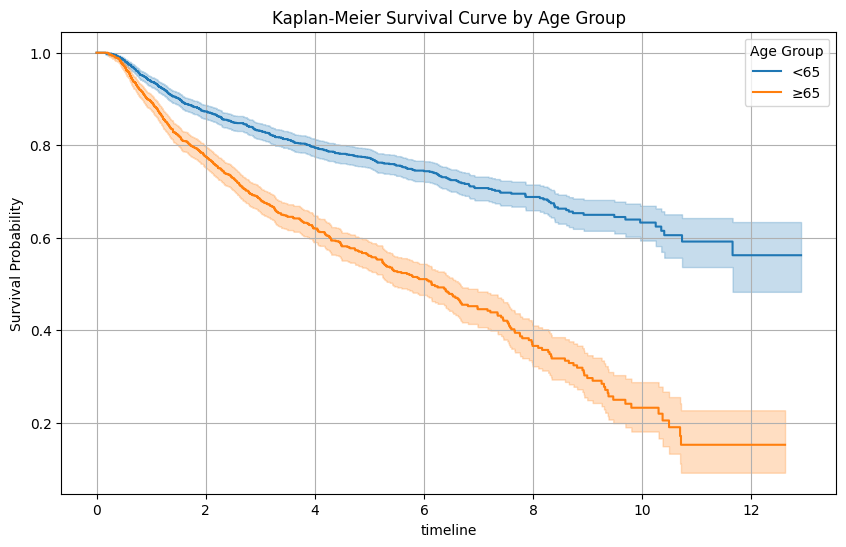

In [4]:
# Kaplan Meier plot & Log-Rank Test 

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Splitting data into groups
group_lt65 = df[df['age_group'] == '<65']
group_gte65 = df[df['age_group'] == '≥65']

# Initializing plot
plt.figure(figsize=(10, 6))
plt.title("Kaplan-Meier Survival Curve by Age Group")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")

# Plotting <65 group
kmf = KaplanMeierFitter()
kmf.fit(durations=group_lt65['survival_time'], event_observed=group_lt65['event'], label="<65")
ax = kmf.plot_survival_function(ci_show=True)

# Plotting ≥65 group
kmf.fit(durations=group_gte65['survival_time'], event_observed=group_gte65['event'], label="≥65")
kmf.plot_survival_function(ci_show=True, ax=ax)

# Setting log-rank test
results = logrank_test(
    group_lt65['survival_time'], group_gte65['survival_time'],
    event_observed_A=group_lt65['event'], event_observed_B=group_gte65['event']
)

# Show p-value
print(f"\n📊 Log-rank test p-value: {results.p_value:.5f}")
if results.p_value < 0.05:
    print("✅ Significant difference in survival between age groups.")
else:
    print("❌ No significant difference in survival between age groups.")

plt.legend(title="Age Group")
plt.grid(True)
plt.show()


In [5]:
# Extra Renaming
# Rename existing cleaned data as cleaned_df
cleaned_df = df.copy()


In [6]:
# Extra checking
print("🧾 cleaned_df columns:\n", cleaned_df.columns.tolist())


🧾 cleaned_df columns:
 ['Age', 'survival_time', 'event', 'age_group']


In [7]:
# Performing a Cox regression analysis, including at least three covariates. 

# Rebuilding
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

# Step 1: Extract and clean
df_cox = df_raw[['Age', 'Sex', 'Dose', 'Length FU', 'Status']].copy()
df_cox = df_cox.dropna(subset=['Age', 'Sex', 'Dose', 'Length FU', 'Status'])

# Step 2: Prepare columns
df_cox['survival_time'] = pd.to_numeric(df_cox['Length FU'], errors='coerce')
df_cox['event'] = df_cox['Status'].map({'Dead': 1, 'Alive': 0})
df_cox['Sex'] = df_cox['Sex'].map({'Male': 1, 'Female': 0})

# Step 3: Final drop to ensure numeric-only for CoxPHFitter
df_clean = df_cox[['Age', 'Sex', 'Dose', 'survival_time', 'event']].dropna()

# Step 4: Fit Cox model
cph = CoxPHFitter()
cph.fit(df_clean, duration_col='survival_time', event_col='event')

# Show summary
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'survival_time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7849.55
         time fit was run = 2025-07-15 01:47:58 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Age        0.04      1.05      0.00            0.04            0.05                1.04                1.05
Sex        0.02      1.02      0.08           -0.13            0.17                0.88                1.19
Dose       0.00      1.00      0.01           -0.01            0.01                0.99                1.01

           cmp to     z      p  -log2(p)
covariate                               
Age          0.00 14.92 <0.005    164.82
Sex          0.00  0.31   0.76      0.40
Dose         0.00  0.70   0.49      1.04
---
Concordance = 0.62
Partial AIC = 15705.10
log-likelihood ratio test = 243.28 on 3 df
-log2(p) of ll-ratio test = 171.84

In [ ]:
# Validation proportional hazards
# Checking proportional hazards assumption
ph_test = proportional_hazard_test(cph, df_clean, time_transform='rank')
ph_test.print_summary()


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
         test_name = proportional_hazard_test

---
      test_statistic      p  -log2(p)
Age            10.91 <0.005     10.03
Dose           10.10 <0.005      9.40
Sex             4.63   0.03      4.99

In [17]:
# Cox Proportional Hazards Comparison:

cph = CoxPHFitter()
cph.fit(df, duration_col='survival_time', event_col='event')
cox_cindex = concordance_index(df['survival_time'], -cph.predict_partial_hazard(df), df['event'])
print(f"📊 Cox C-index: {cox_cindex:.3f}")


📊 Cox C-index: 0.621


In [74]:
# Analyzing with Random Survival Forest (RSF)
!pip install scikit-survival


In [9]:
# Extra
import pandas as pd

# Load the first few rows from the correct sheet
df_raw = pd.read_excel("RADCURE_Clinical_v04_20241219.xlsx", sheet_name=0)  # or try without header
print("📋 Column names:\n", df_raw.columns.tolist())
df_raw.head()


📋 Column names:
 ['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status', 'Ds Site', 'Subsite', 'T', 'N', 'M ', 'Stage', 'Path', 'HPV', 'Tx Modality', 'Chemo', 'RT Start', 'Dose', 'Fx', 'Last FU', 'Status', 'Length FU', 'Date of Death', 'Cause of Death', 'Local', 'Date Local', 'Regional', 'Date Regional', 'Distant', 'Date Distant', '2nd Ca', 'Date 2nd Ca', 'RADCURE-challenge', 'ContrastEnhanced']


,patient_id,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,...,Local,Date Local,Regional,Date Regional,Distant,Date Distant,2nd Ca,Date 2nd Ca,RADCURE-challenge,ContrastEnhanced
0,RADCURE-0005,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0
1,RADCURE-0006,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
2,RADCURE-0007,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Tonsil,T3,N2b,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
3,RADCURE-0009,72.3,Male,ECOG 1,30,Ex-smoker,Unknown,NaN,T0,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,S (suspicious),2008-05-27,0,0
4,RADCURE-0010,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Tonsillar Fossa,T4b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0


In [10]:
# Step for checking
import os

# List files in the current directory
print("Current working directory:", os.getcwd())
print("\nFiles in the directory:")
for file in os.listdir():
    print(file)


Current working directory: /home/codespace/BINF-5507-assignment-4-1

Files in the directory:
.git
BINF-5507-assignment-4-6
RADCURE_Clinical_v04_20241219.xlsx
README.md
LICENSE
main.ipynb


In [77]:
# Extra
print("Unique values in event column:", df_rsf['event'].unique())


Unique values in event column: []


In [15]:
# Extra
# ✅ Step 1: Load raw Excel with no header
df_raw = pd.read_excel("RADCURE_Clinical_v04_20241219.xlsx", 
                       sheet_name="RADCURE_TCIA_Clinical_r2_offset", 
                       header=None)

# ✅ Step 2: Set real column names from first row
df_raw.columns = df_raw.iloc[0]
df_raw = df_raw.iloc[1:].reset_index(drop=True)

# ✅ Step 3: Rename columns for consistency
df_raw = df_raw.rename(columns={
    'Length FU': 'survival_time',
    'Status': 'event'
})

# ✅ Step 4: Select necessary columns
df = df_raw[['Age', 'Sex', 'Dose', 'survival_time', 'event']].copy()

# ✅ Step 5: Clean and encode
df = df.dropna()
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Dose'] = pd.to_numeric(df['Dose'], errors='coerce')
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})
df['event'] = df['event'].map({'Dead': 1, 'Alive': 0})
df = df.dropna()

# Final check
print("✅ Cleaned dataset shape:", df.shape)
print("🎯 Unique event values:", df['event'].unique())


✅ Cleaned dataset shape: (3346, 5)
🎯 Unique event values: [1 0]


In [16]:
# Random Survival Forest (RSF) Analysis

from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt

# Survival structured array
y_rsf = Surv.from_dataframe('event', 'survival_time', df)
X_rsf = df[['Age', 'Sex', 'Dose']]

# RSF model
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=42)
rsf.fit(X_rsf, y_rsf)

# C-index
rsf_cindex = rsf.score(X_rsf, y_rsf)
print(f"📊 RSF C-index: {rsf_cindex:.3f}")


📊 RSF C-index: 0.679


In [20]:
# Evaluation with train_test_split

# 📦 Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

# ✅ Step 1: Load and fix header
file = "RADCURE_Clinical_v04_20241219.xlsx"
df_raw = pd.read_excel(file, sheet_name="RADCURE_TCIA_Clinical_r2_offset", header=None)

# ✅ Step 2: Set proper column headers from 2nd row (index 1)
df_raw.columns = df_raw.iloc[0]
df_raw = df_raw.iloc[2:].reset_index(drop=True)  # skip metadata row and header row

# ✅ Step 3: Rename and extract key columns
df_raw = df_raw.rename(columns={"Length FU": "survival_time", "Status": "event"})
df = df_raw[["Age", "Sex", "Dose", "survival_time", "event"]].copy()

# ✅ Step 4: Clean and encode
df = df.dropna()
df["event"] = df["event"].map({"Dead": 1, "Alive": 0})
df["Sex"] = df["Sex"].map({"Male": 1, "Female": 0})
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df["Dose"] = pd.to_numeric(df["Dose"], errors="coerce")
df["survival_time"] = pd.to_numeric(df["survival_time"], errors="coerce")
df = df.dropna()

# ✅ Step 5: Prepare data for RSF
X = df[["Age", "Sex", "Dose"]]
y = Surv.from_dataframe("event", "survival_time", df)

# ✅ Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ Step 7: Fit RSF
rsf = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
)
rsf.fit(X_train, y_train)

# ✅ Step 8: Evaluate
train_cindex = rsf.score(X_train, y_train)
test_cindex = rsf.score(X_test, y_test)

print(f"✅ RSF Train C-index: {train_cindex:.3f}")
print(f"📊 RSF Test C-index : {test_cindex:.3f}")


✅ RSF Train C-index: 0.685
📊 RSF Test C-index : 0.637
